# Installation, data loading, and imports

In [1]:
!pisces_setup

Converting Mads Olsen model to Keras...
Model saved at /Users/eric/Engineering/Work/pisces/pisces/cached_models/mo_resunet.keras


In [2]:
import numpy as np
from typing import List
import tensorflow as tf
import pisces.models as pm
from importlib import reload
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
from pisces.utils import pad_to_hat, plot_scores_CDF, plot_scores_PDF, add_rocs
from pisces.data_sets import DataSetObject, ModelInputSpectrogram, ModelOutputType, DataProcessor, PSGType
import utils.analysis as ua
from importlib import reload
reload(ua)
from scipy.special import softmax

import os
from pathlib import Path

CWD = Path(os.getcwd())
# NB! these are different from preprocess_data.ipynb
save_path = CWD.joinpath("fine_tuning")

hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
disordered_path = save_path.joinpath("disordered")
os.makedirs(disordered_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)



In [3]:
MAX_PSG_EPOCHS = 1024
WASA_SLEEP_ACCURACY = 0.97
WASA_COLUMN = f"WASA{int(WASA_SLEEP_ACCURACY*100)}"
AUROC_COLUMN = "AUROC"
ACCURACY_COLUMN = "WeightedAccuracy"
EVALUATION_COLUMNS = [WASA_COLUMN, ACCURACY_COLUMN, AUROC_COLUMN]

input_shape = (-1, 2048, 1)
output_shape = (-1, 1024, 1)

In [4]:
epochs = 15
break_up_line = "=" * 20

# TF Model Definitions

In [5]:
from dataclasses import dataclass
from sklearn.calibration import expit
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom loss function that takes weights into account
def weighted_binary_crossentropy(y_true, y_pred, sample_weight):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)[..., None]
    weighted_bce = bce * sample_weight
    return tf.reduce_mean(weighted_bce)

def make_mo_model():
    sampling_hz = 32 # Hz
    input_features = ['accelerometer']
    model_input = ModelInputSpectrogram(input_features, sampling_hz)
    output_type = ModelOutputType.WAKE_LIGHT_DEEP_REM
    mo = pm.MOResUNetPretrained(data_processor=None, sampling_hz=sampling_hz, lazy_model_loading=False)

    return mo

# Function to build the CNN-based mixture model
def build_smartmap_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)  # Input shape (1024, 4)

    # First 1D Convolutional Layer
    x = tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding='same', activation='linear')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # # Second 1D Convolutional Layer
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, padding='same', activation='linear')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # x = tf.keras.layers.Dropout(0.1)(x)

    # Output Layer: Binary classification (Wake or Sleep)
    x = tf.keras.layers.Conv1D(filters=2, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=1, kernel_size=1, activation='linear')(x)

    # The output shape will be (1024, 1) per example, representing the probability of Sleep at each timestep
    return tf.keras.Model(inputs=inputs, outputs=x)

def cnn_pred_proba(cnn, data):
    return expit(
        cnn.predict(
            data.reshape(1, 1024, 4)
        )).reshape(-1,)

def naive_pred_proba(data):
    return 1 - softmax(data, axis=-1)[:, 0]

In [6]:

# Custom model class
class WeightedModel(tf.keras.Model):
    def __init__(self, original_model):
        super(WeightedModel, self).__init__()
        self.original_model = original_model

    def call(self, inputs):
        x = inputs
        return self.original_model(x)

    def train_step(self, data):
        x, y_true, sample_weight = data

        with tf.GradientTape() as tape:
            y_pred = self.original_model(x, training=True)
            loss = weighted_binary_crossentropy(y_true, y_pred, sample_weight)

        # Compute gradients and update weights
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            metric.update_state(y_true, y_pred)
        return {"loss": loss}

# Original model
def build_lr_cnn(kernel_size: int = 21):
    input_layer = layers.Input(shape=(2048, 1), name="activity_input")
    x = layers.Conv1D(filters=1, kernel_size=kernel_size, strides=2, padding="same")(input_layer)
    x = layers.BatchNormalization()(x)
    model = models.Model(inputs=input_layer, outputs=x)
    return model

# SECONDS_PER_EPOCH = 15
# SECONDS_PER_WINDOW = 5 * 60 + SECONDS_PER_EPOCH
# EPOCHS_PER_WINDOW = int(SECONDS_PER_WINDOW / SECONDS_PER_EPOCH)


def lr_cnn_pred_proba(lr_cnn, data: tf.Tensor):
    return expit(
        lr_cnn.predict(
            tf.reshape(data, (1, 2048, 1))
        )).reshape(-1,)
# Create original and weighted models
original_model = build_lr_cnn()
weighted_model = WeightedModel(original_model)

# Compile the model with an optimizer
weighted_model.compile(optimizer='adam', metrics=['auc'])

# Generate dummy data
import numpy as np

N_SAMPLES = 5
x_data = tf.random.normal((N_SAMPLES, 2048, 1), dtype=tf.float32)
y_data = tf.random.normal((N_SAMPLES, 1024, 1), dtype=tf.float32)
sample_weights = tf.random.normal((N_SAMPLES, 1024, 1), dtype=tf.float32)

# Train the model using a dataset
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, sample_weights))
dataset = dataset.batch(1)

# Fit the model
weighted_model.fit(dataset, epochs=2, validation_data=None)


Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0180
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: -0.0187


# Weighting and analysis functions

In [7]:
import json

import pandas as pd
from scipy.special import expit
from sklearn.metrics import auc, roc_curve
from sklearn.utils import class_weight
import numpy as np

def compute_sample_weights(labels: np.ndarray, verbose: bool = False) -> np.ndarray:
    mask_weights = labels >= 0
    if verbose:
        print(f"Scored % of {labels.size} epochs:\n{100 * (np.sum(mask_weights) / mask_weights.size):.2f} ({np.sum(mask_weights)} / {mask_weights.size})")

    # balanced class weights
    # Count the occurrences of each class
    # class_counts = {
    #     0: np.sum(labels == 0),
    #     1: np.sum(labels == 1),
    # }
    # print(class_counts)
    # total_samples = np.sum(mask_weights)
    # num_classes = 2

    # # Calculate the class weights
    # class_weights = {
    #     i: total_samples / (num_classes * count)
    #     # i: 1.0 / (num_classes * count)
    #     for i, count in class_counts.items()
    # } 
    class_weight_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=labels[mask_weights].flatten()
    )
    class_weights = {0: class_weight_array[0], 1: class_weight_array[1]}
    if verbose:
        print("Class weights:\n", json.dumps(class_weights, indent=2)) # pretty print
    class_weights |= {-1: 0.0}

    def weight_fn(x):
        return class_weights[x]
    
    wfv = np.vectorize(weight_fn)
    sample_weights = wfv(labels)

    return sample_weights

def masked_weighted_accuracy(y_true, y_pred, sample_weight):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    sample_weight = tf.cast(sample_weight, tf.float32)
    correct = tf.cast(tf.equal(y_true, y_pred), tf.float32)
    weighted_accuracy = tf.reduce_sum(correct * sample_weight) / tf.reduce_sum(sample_weight)

    return weighted_accuracy.numpy()



def auroc_balaccuracy_wasa(split_name, binary_pred_proba, test_sample_weights, test_labels_masked, sleep_accuracy=WASA_SLEEP_ACCURACY):

    flat_test_labels = test_labels_masked.reshape(-1,)
    flat_weights = test_sample_weights.reshape(-1,)

    # # compute AUROC
    fpr, tpr, thresholds = roc_curve(flat_test_labels, binary_pred_proba, sample_weight=flat_weights)
    roc_auc = auc(fpr, tpr)

    # # compute WASA
    wasa_threshold = thresholds[np.sum(tpr <= sleep_accuracy)]
    y_guess = binary_pred_proba > wasa_threshold
    guess_right = y_guess == flat_test_labels
    y_wake = (flat_test_labels == 0) & (flat_weights > 0)
    n_wake = np.sum(y_wake)
    n_wake_right = np.sum(y_wake & guess_right)
    wake_accuracy = n_wake_right / n_wake

    weighted_accuracy = masked_weighted_accuracy(
        flat_test_labels,
        y_guess,
        flat_weights)

    print("=" * 20)
    print(f"Fold {split_name}")
    print(f"\tROC AUC: {roc_auc}")
    print(f"\tTest WEIGHTED accuracy: {weighted_accuracy}")
    print(f"\t{WASA_COLUMN}: {wake_accuracy} ({n_wake_right} / {n_wake} || threshold: {wasa_threshold})")
    print("=" * 20)
    return roc_auc, weighted_accuracy, wake_accuracy


def evaluate_auroc_wasa_balanced_accuracy(
        predictors,  # list of models, pretty flexible as predictors[i] is passed to evaluators[i] with preprocessed_data[i]
        evaluators,  # list of functions that take (predictor, sample) -> probability of sleep
        preprocessed_data):
    keys = list(preprocessed_data.keys())
    evaluations = []
    for eval_fn, predictor, split_name in zip(evaluators, predictors, keys):
        test_data, test_labels, test_specgrams = preprocessed_data[split_name]
        test_sample_weights = compute_sample_weights(test_labels)
        evaluations.append(
            auroc_balaccuracy_wasa(
            split_name, 
            eval_fn(predictor, test_data),
            test_data, 
            test_sample_weights, 
            test_labels
            )
        )
    evaluations_df = pd.DataFrame(evaluations, columns=EVALUATION_COLUMNS)

    return evaluations_df


from dataclasses import dataclass

@dataclass
class PreparedData:
    activity: tf.Tensor 
    spectrogram: tf.Tensor 
    mo_predictions: tf.Tensor 
    true_labels: tf.Tensor 
    sample_weights: tf.Tensor 


def prepare_data(preprocessed_data: dict):
    mo = make_mo_model()
    keys = list(preprocessed_data.keys())
    xyz_specgram_input = np.array([
        preprocessed_data[k]['spectrogram']
        for k in keys
    ])
    xyz_average = xyz_specgram_input #np.mean(xyz_specgram_input, axis=-1)

    specgram_input = np.zeros((*xyz_average.shape, 2))
    # embed x,y,z into 2 channels
    # one is reflected along the frequency axis
    specgram_input[..., 0] = xyz_average
    specgram_input[..., 1] = xyz_average[..., ::-1]
    
    mo_predictions = mo.predict_logits(specgram_input)

    full_labels = np.array([
        preprocessed_data[k]['psg'][:, 1]
        for k in keys
    ])
    labels = np.where(full_labels > 0, 1, full_labels)

    # in original setup, specgrams were average of x,y,z
    # specgrams = np.mean(xyz_specgram_input, axis=-1)
    specgrams = xyz_specgram_input

    activity = np.array([
        preprocessed_data[k]['activity'][:, 1]
        for k in keys
    ])
    weights = np.array([
        compute_sample_weights(labels[i])
        for i in range(labels.shape[0])
    ])
    return PreparedData(
        activity=tf.convert_to_tensor(activity, dtype=tf.float32),
        spectrogram=tf.convert_to_tensor(specgrams, dtype=tf.float32),
        mo_predictions=tf.convert_to_tensor(mo_predictions, dtype=tf.float32),
        true_labels=tf.convert_to_tensor(labels, dtype=tf.float32),
        sample_weights=tf.convert_to_tensor(weights, dtype=tf.float32)
    )


# Plotting functions

In [8]:
from matplotlib import rcParams
import pandas as pd
import seaborn as sns

color_palette = sns.color_palette("colorblind")
# Convert evaluations to a DataFrame

def tri_plot_metrics(evaluations_df: List[tuple], save_dir: Path | None = None, PLOT_TITLE: str = "Metrics", axs: List[plt.Axes] | None = None, axs_set_name: str | None = None, filename: str | None = None):
    # Plot metrics
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig = axs[0].figure

    metrics = {
        'sw_accuracy': evaluations_df[ACCURACY_COLUMN],
        'auc': evaluations_df[WASA_COLUMN],
        'wasa': evaluations_df[AUROC_COLUMN]
    }

    rcParams['font.family'] = 'Helvetica'  # Change to 'Helvetica' if available
    rcParams['font.size'] = 12  # Optional: Set a global font size

    metrics_dimensions = {'sw_accuracy': 'Balanced Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
    metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

    if axs_set_name is not None:
        axs[0].set_title(axs_set_name)

    for metric, ax in zip(metrics_dimensions.keys(), axs):
        sns.histplot(metrics[metric], bins=20, kde=True, color=metric_colors[metric], ax=ax)
        ax.axvline(np.mean(metrics[metric]), color='red', linestyle='dashed', linewidth=2, label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.5f}")
        # ax.set_title(metrics_dimensions[metric])
        ax.set_xlabel(metrics_dimensions[metric])
        ax.set_xlim(0, 1)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Optional: Customize the remaining spines (left and bottom)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)

        ax.set_ylabel('Count')
        ax.legend()

    fig.suptitle(PLOT_TITLE,
                 fontsize=20)
    fig.tight_layout()
    if save_dir is not None:
        if filename is None:
            filename = 'tri_plot_metrics.png'
        fig.savefig(save_dir.joinpath(filename), dpi=600, bbox_inches='tight')

In [9]:
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

def add_spectrogram(ax, specgram):
    ax.imshow(specgram.T, aspect='auto', origin='lower', vmax=20, vmin=-20)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Specgram')
    ax.set_ylabel('Frequency')

def add_smartmap_inputs(ax, input_data):
    input_t = input_data.T
    INPUT_EPOCHS = input_data.shape[0]
    ax.stackplot(range(INPUT_EPOCHS), softmax(input_t, axis=0))
    ax.set_xlim(0, INPUT_EPOCHS)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'SmartMap Training Input')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time (epochs)')

def add_lr_inputs(ax, input_data):
    cnn_input_width = input_data.shape[0]
    ax.plot(range(cnn_input_width), input_data)
    ax.set_xlim(0, cnn_input_width)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Actigraphy')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time (epochs)')

def add_hypnogram(ax, binary_pred_proba, true_labels, naive_prediction, model_type):
    binary_label = 'SmartMap Prediction' if model_type == 'smartmap' else 'LR Prediction'
    ax.plot(binary_pred_proba, label=binary_label)
    if naive_prediction is not None:
        ax.plot(naive_prediction, label='Naive: 1 - P(wake)')

    sample_weight = compute_sample_weights(true_labels)
    masked_true_labels = np.where(sample_weight, true_labels, -1)

    ax.plot(masked_true_labels, label='Actual', linestyle='--')
    ax.set_xlim(0, len(binary_pred_proba))
    ax.set_ylabel('Probability of Sleep')
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Hypnogram')
    ax.legend()

    return masked_true_labels, sample_weight


def add_roc(ax, binary_pred_proba, true_labels, sample_weight, naive_prediction: np.ndarray | None = None):
    masked_true_labels = np.where(sample_weight, true_labels, 0)
    fpr, tpr, thresholds = roc_curve(masked_true_labels, binary_pred_proba, sample_weight=sample_weight)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

    roc_auc_naive = None
    if naive_prediction is not None:
        # Plot the ROC curve from naive_prediction
        fpr_naive, tpr_naive, _ = roc_curve(masked_true_labels, naive_prediction, sample_weight=sample_weight)
        roc_auc_naive = auc(fpr_naive, tpr_naive)
        ax.plot(fpr_naive, tpr_naive, color='green', lw=2, label=f'Naive ROC curve (area = {roc_auc_naive:.2f})')
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Wake Predicted as Sleep')
    ax.set_ylabel('Sleep Predicted as Sleep')
    ax.legend(loc="lower right")

    return roc_auc, roc_auc_naive

from typing import List
def ranked_debug_plots(df, eval_data, true_labels, predictors, evaluator, specgrams, filename_suffix: str, model_type: str, split_names: List[str] = None):
    indices = df.sort_values(ACCURACY_COLUMN, ascending=False).index
    aurocs = []
    

    for rank, idx in enumerate(indices):
        if idx >= len(eval_data):
            continue
        fig, axs = plt.subplots(4, 1, figsize=(10, 15))
        fig.subplots_adjust(hspace=0, left=0)
        
        # Plot the specgram
        _ = add_spectrogram(axs[0], specgrams[idx])
        
        # Plot the CNN training input as a stacked area plot
        if model_type == 'smartmap':
            add_smartmap_inputs(axs[1], eval_data[idx].squeeze(), )
        elif model_type == 'lr':
            add_lr_inputs( axs[1], eval_data[idx].squeeze(),)
        
        # Plot the final output along with the correct value

        binary_pred_proba = evaluator(predictors[idx], eval_data[idx]).squeeze()
        naive_prediction = 1 - eval_data[idx][:, 0] if model_type == 'smartmap' else None
        masked_true_labels, sample_weight = add_hypnogram(
            axs[2],
            binary_pred_proba,
            true_labels[idx],
            naive_prediction,
            model_type
        )

        auroc, *_ = add_roc(
            ax=axs[3], 
            binary_pred_proba=binary_pred_proba, 
            true_labels=true_labels[idx], 
            sample_weight=sample_weight, 
            naive_prediction=naive_prediction
        )

        aurocs.append(auroc)

        if split_names is None:
            split_names = [f"split {i}" for i in range(len(eval_data))]
        fig.suptitle(f'#{rank} {split_names[idx]} Weighted Accuracy: {df.loc[idx, ACCURACY_COLUMN]} {WASA_COLUMN}: {df.loc[idx, WASA_COLUMN]}',
                    fontsize=16, fontweight='bold')
        
        fig.tight_layout(pad=0.1)
        plt.savefig(walch_path.joinpath(f"{split_names[idx]}_rank_{rank}_{filename_suffix}.png"))
        plt.close()

    sns.histplot(aurocs, bins=20, kde=True, color='blue', ax=plt.gca(), )
    plt.xlabel('AUROC')
    plt.ylabel('Count')
    plt.title('Distribution of AUROCs')
    plt.show()


# Arcascope's SmartMap

In [10]:
dataset = "walch"
walch_preprocessed_data = np.load('./pre_processed_data/walch/walch_preprocessed_data.npy',
                                   allow_pickle=True).item()

In [11]:
walch_preprocessed_data['1818471'].keys()

dict_keys(['spectrogram', 'activity', 'psg'])

In [12]:
walch_preprocessed_data.keys()

dict_keys(['1066528', '1360686', '1449548', '1455390', '1818471', '2598705', '2638030', '3997827', '4018081', '4314139', '4426783', '46343', '5498603', '5797046', '6220552', '781756', '8000685', '8173033', '844359', '8530312', '8686948', '8692923', '9106476', '9618981'])

In [13]:

split_maker = pm.LeaveOneOutSplitter()

## Create data tensors for training + evaluating

In [14]:
walch_preprocessed_data.keys()

dict_keys(['1066528', '1360686', '1449548', '1455390', '1818471', '2598705', '2638030', '3997827', '4018081', '4314139', '4426783', '46343', '5498603', '5797046', '6220552', '781756', '8000685', '8173033', '844359', '8530312', '8686948', '8692923', '9106476', '9618981'])

In [15]:
walch_preprocessed_data['1066528']['spectrogram'].shape

(15360, 32)

In [16]:
walch_keys = list(walch_preprocessed_data.keys())
walch_data_bundle = prepare_data(walch_preprocessed_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [17]:
walch_data_bundle.mo_predictions.shape

TensorShape([24, 1024, 4])

In [18]:
walch_data_bundle.spectrogram.shape

TensorShape([24, 15360, 32])

## Training

In [19]:
import pandas as pd
from sklearn.calibration import expit
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

SHAPE = (MAX_PSG_EPOCHS, 4)
split_maker = pm.LeaveOneOutSplitter()

training_results = []
evaluations = []
cnn_predictors = []

print("Training models...")
print("Saving models to", walch_path)

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data = tf.reshape(
        tf.gather(walch_data_bundle.mo_predictions, train_idx_tensor),
        (-1, *SHAPE))
    train_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, train_idx_tensor),
        output_shape)
    train_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, train_idx_tensor),
        output_shape)
    # testing
    test_data = tf.reshape(
        tf.gather(walch_data_bundle.mo_predictions, test_idx_tensor),
        (-1, *SHAPE))
    test_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, test_idx_tensor),
        output_shape)
    test_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, test_idx_tensor),
        output_shape)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)
    test_labels_masked = tf.where(test_sample_weights > 0, test_labels, 0.0)

    # Train the model on the training set
    cnn = build_smartmap_model(SHAPE)
    cnn.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
    )

    # gives weight 0 to -1 "mask" intervals, 1 to the rest


    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights,
    # we can just set the labels to 0
    train_labels_masked = np.where(train_sample_weights, train_labels, 0)

    training_results.append(cnn.fit(
        train_data, train_labels_masked, 
        epochs=100, 
        validation_split=0.0, 
        callbacks=[],
        batch_size=1,
        sample_weight=train_sample_weights,
        verbose=0,
    ))

    # Evaluate the model on the testing set

    accuracy_metrics = auroc_balaccuracy_wasa(
        walch_keys[k_test[0]],
        cnn_pred_proba(cnn, test_data.numpy()),
        test_sample_weights.numpy(),
        test_labels_masked.numpy())

    # # Save all the results
    evaluations.append(accuracy_metrics)

    cnn_predictors.append(cnn)
    # cnn.save(walch_path.joinpath(f"{k_test[0]}_cnn.h5"))


evaluations_df = pd.DataFrame(evaluations, columns=EVALUATION_COLUMNS)


Training models...
Saving models to /Users/eric/Engineering/Work/sleepers_analysis/notebooks/fine_tuning/walch


Next split:   0%|          | 0/24 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:   4%|▍         | 1/24 [00:05<02:01,  5.28s/it]

Fold 1066528
	ROC AUC: 0.7370304991664214
	Test WEIGHTED accuracy: 0.5755370259284973
	WASA97: 0.18181818181818182 (24 / 132 || threshold: 0.04885270446538925)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:   8%|▊         | 2/24 [00:10<01:55,  5.23s/it]

Fold 1360686
	ROC AUC: 0.963644648182923
	Test WEIGHTED accuracy: 0.8257207870483398
	WASA97: 0.6818181818181818 (60 / 88 || threshold: 0.12861648201942444)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  12%|█▎        | 3/24 [00:15<01:47,  5.11s/it]

Fold 1449548
	ROC AUC: 0.8862932445067787
	Test WEIGHTED accuracy: 0.7464352250099182
	WASA97: 0.5869565217391305 (54 / 92 || threshold: 0.25944554805755615)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  17%|█▋        | 4/24 [00:20<01:42,  5.11s/it]

Fold 1455390
	ROC AUC: 0.7625718390804598
	Test WEIGHTED accuracy: 0.7100573182106018
	WASA97: 0.45 (36 / 80 || threshold: 0.369271457195282)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  21%|██        | 5/24 [00:25<01:37,  5.15s/it]

Fold 1818471
	ROC AUC: 0.9858649789029535
	Test WEIGHTED accuracy: 0.8857592940330505
	WASA97: 0.8 (8 / 10 || threshold: 0.05119979381561279)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  25%|██▌       | 6/24 [00:30<01:32,  5.14s/it]

Fold 2598705
	ROC AUC: 0.8996621621621622
	Test WEIGHTED accuracy: 0.8730695843696594
	WASA97: 0.9285714285714286 (13 / 14 || threshold: 0.2648915946483612)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Next split:  29%|██▉       | 7/24 [00:35<01:27,  5.12s/it]

Fold 2638030
	ROC AUC: 0.9430647942843065
	Test WEIGHTED accuracy: 0.8730968236923218
	WASA97: 0.7886178861788617 (97 / 123 || threshold: 0.27409330010414124)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Next split:  33%|███▎      | 8/24 [00:40<01:21,  5.09s/it]

Fold 3997827
	ROC AUC: 0.9958234660925727
	Test WEIGHTED accuracy: 0.9865446090698242
	WASA97: 1.0 (25 / 25 || threshold: 0.31387877464294434)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Next split:  38%|███▊      | 9/24 [00:46<01:16,  5.12s/it]

Fold 4018081
	ROC AUC: 0.9083165044978887
	Test WEIGHTED accuracy: 0.8614098429679871
	WASA97: 0.7538461538461538 (49 / 65 || threshold: 0.24031740427017212)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Next split:  42%|████▏     | 10/24 [00:51<01:13,  5.26s/it]

Fold 4314139
	ROC AUC: 0.8310408637129758
	Test WEIGHTED accuracy: 0.7278386354446411
	WASA97: 0.48484848484848486 (48 / 99 || threshold: 0.2884625792503357)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  46%|████▌     | 11/24 [00:56<01:08,  5.24s/it]

Fold 4426783
	ROC AUC: 0.927647953539823
	Test WEIGHTED accuracy: 0.8483129143714905
	WASA97: 0.71875 (46 / 64 || threshold: 0.3041333556175232)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Next split:  50%|█████     | 12/24 [01:02<01:03,  5.30s/it]

Fold 46343
	ROC AUC: 0.9251977004669238
	Test WEIGHTED accuracy: 0.9143883585929871
	WASA97: 0.8607594936708861 (68 / 79 || threshold: 0.6929120421409607)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  54%|█████▍    | 13/24 [01:07<00:57,  5.24s/it]

Fold 5498603
	ROC AUC: 0.9397789218655361
	Test WEIGHTED accuracy: 0.6573289036750793
	WASA97: 0.34615384615384615 (36 / 104 || threshold: 0.01676688902080059)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  58%|█████▊    | 14/24 [01:12<00:51,  5.20s/it]

Fold 5797046
	ROC AUC: 0.6960468976966175
	Test WEIGHTED accuracy: 0.6764074563980103
	WASA97: 0.379746835443038 (30 / 79 || threshold: 0.6219747066497803)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  62%|██████▎   | 15/24 [01:17<00:46,  5.13s/it]

Fold 6220552
	ROC AUC: 0.8892247663150674
	Test WEIGHTED accuracy: 0.7486067414283752
	WASA97: 0.5384615384615384 (28 / 52 || threshold: 0.25754526257514954)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  67%|██████▋   | 16/24 [01:22<00:40,  5.09s/it]

Fold 781756
	ROC AUC: 0.8682871182871185
	Test WEIGHTED accuracy: 0.8361560702323914
	WASA97: 0.8051948051948052 (62 / 77 || threshold: 0.2693112790584564)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  71%|███████   | 17/24 [01:27<00:35,  5.06s/it]

Fold 8000685
	ROC AUC: 0.94026284348865
	Test WEIGHTED accuracy: 0.8856848478317261
	WASA97: 0.8387096774193549 (26 / 31 || threshold: 0.25875815749168396)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Next split:  75%|███████▌  | 18/24 [01:32<00:30,  5.02s/it]

Fold 8173033
	ROC AUC: 0.9847782182661381
	Test WEIGHTED accuracy: 0.915850043296814
	WASA97: 0.8620689655172413 (25 / 29 || threshold: 0.18672291934490204)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  79%|███████▉  | 19/24 [01:37<00:25,  5.02s/it]

Fold 844359
	ROC AUC: 0.9206303646602155
	Test WEIGHTED accuracy: 0.7158437967300415
	WASA97: 0.46153846153846156 (42 / 91 || threshold: 0.025384817272424698)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  83%|████████▎ | 20/24 [01:42<00:20,  5.08s/it]

Fold 8530312
	ROC AUC: 0.9062256149279051
	Test WEIGHTED accuracy: 0.7393385171890259
	WASA97: 0.5066666666666667 (38 / 75 || threshold: 0.03690697252750397)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  88%|████████▊ | 21/24 [01:47<00:15,  5.05s/it]

Fold 8686948
	ROC AUC: 0.9678135405105439
	Test WEIGHTED accuracy: 0.9678134918212891
	WASA97: 1.0 (49 / 49 || threshold: 0.2710159718990326)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  92%|█████████▏| 22/24 [01:52<00:10,  5.06s/it]

Fold 8692923
	ROC AUC: 0.9791685144124169
	Test WEIGHTED accuracy: 0.9350886940956116
	WASA97: 0.8909090909090909 (98 / 110 || threshold: 0.4300886392593384)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  96%|█████████▌| 23/24 [01:57<00:05,  5.07s/it]

Fold 9106476
	ROC AUC: 0.656221198156682
	Test WEIGHTED accuracy: 0.6125849485397339
	WASA97: 0.24705882352941178 (21 / 85 || threshold: 0.2949706017971039)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split: 100%|██████████| 24/24 [02:02<00:00,  5.12s/it]

Fold 9618981
	ROC AUC: 0.9165075309306079
	Test WEIGHTED accuracy: 0.6891608238220215
	WASA97: 0.4090909090909091 (36 / 88 || threshold: 0.1587899774312973)


## Ranked specgram + prediction plots
1. Spectrogram
2. Staging probabilities
3. Hypnogram with CNN and naive binarization
4. ROC curve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


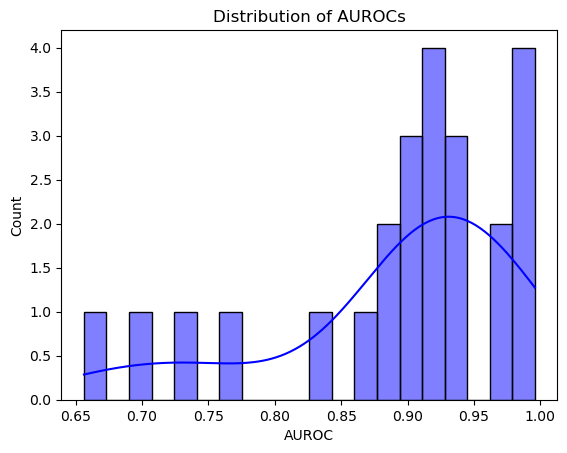

In [20]:
ranked_debug_plots(
    evaluations_df,
    walch_data_bundle.mo_predictions.numpy(),
    walch_data_bundle.true_labels.numpy(),
    cnn_predictors,
    cnn_pred_proba,
    walch_data_bundle.spectrogram.numpy(),
    "_cnn_eval_stationary",
    "smartmap",
    walch_keys
)

## Hybrid data set

In [21]:
dataset = "hybrid"
hybrid_preprocessed_data = np.load(f'./pre_processed_data/{dataset}/{dataset}_preprocessed_data.npy',
                                   allow_pickle=True).item()

In [22]:
hybrid_keys = list(hybrid_preprocessed_data.keys())
hybrid_data_bundle = prepare_data(hybrid_preprocessed_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [23]:

# Import necessary libraries
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

results = []
for idx in range(len(hybrid_preprocessed_data)):
    hybrid_weights = hybrid_data_bundle.sample_weights[idx].numpy()
    hybrid_labels = hybrid_data_bundle.true_labels[idx].numpy()
    hybrid_labels_masked = np.where(hybrid_weights, hybrid_labels, 0)

    eval = auroc_balaccuracy_wasa(
        hybrid_keys[idx], 
        cnn_pred_proba(cnn_predictors[idx],
        hybrid_data_bundle.mo_predictions[idx].numpy()),
        hybrid_weights,
        hybrid_labels_masked)
    results.append(eval)

evaluations_df_hybrid = pd.DataFrame(results, columns=EVALUATION_COLUMNS)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1066528
	ROC AUC: 0.6499197021680415
	Test WEIGHTED accuracy: 0.5447781682014465
	WASA97: 0.12030075187969924 (16 / 133 || threshold: 0.03696645051240921)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1360686
	ROC AUC: 0.9544765004413063
	Test WEIGHTED accuracy: 0.8930935859680176
	WASA97: 0.8068181818181818 (71 / 88 || threshold: 0.1295377016067505)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 1449548
	ROC AUC: 0.9018961729679731
	Test WEIGHTED accuracy: 0.7284946441650391
	WASA97: 0.5161290322580645 (48 / 93 || threshold: 0.25944554805755615)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 1455390
	ROC AUC: 0.7431885908897402
	Test WEIGHTED accuracy: 0.7387183308601379
	WASA97: 0.5061728395061729 (41 / 81 || threshold: 0.6285543441772461)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1818471
	ROC AUC: 0.994198312236287
	Test WEIGHTED accuracy: 0.9857594966888428
	WASA97: 1.0 (10 / 10 || threshold: 0.2489398568868637)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


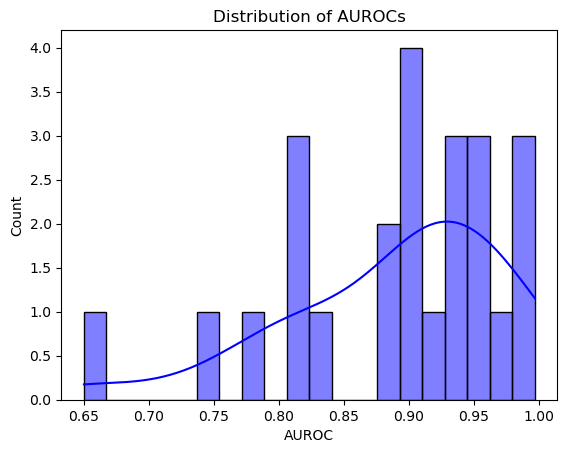

In [24]:
ranked_debug_plots(
    evaluations_df_hybrid,
    hybrid_data_bundle.mo_predictions.numpy(),
    hybrid_data_bundle.true_labels.numpy(),
    cnn_predictors,
    cnn_pred_proba,
    hybrid_data_bundle.spectrogram.numpy(),
    "_cnn_eval_hybrid",
    "smartmap",
    walch_keys
)

## Tri plot for UNet

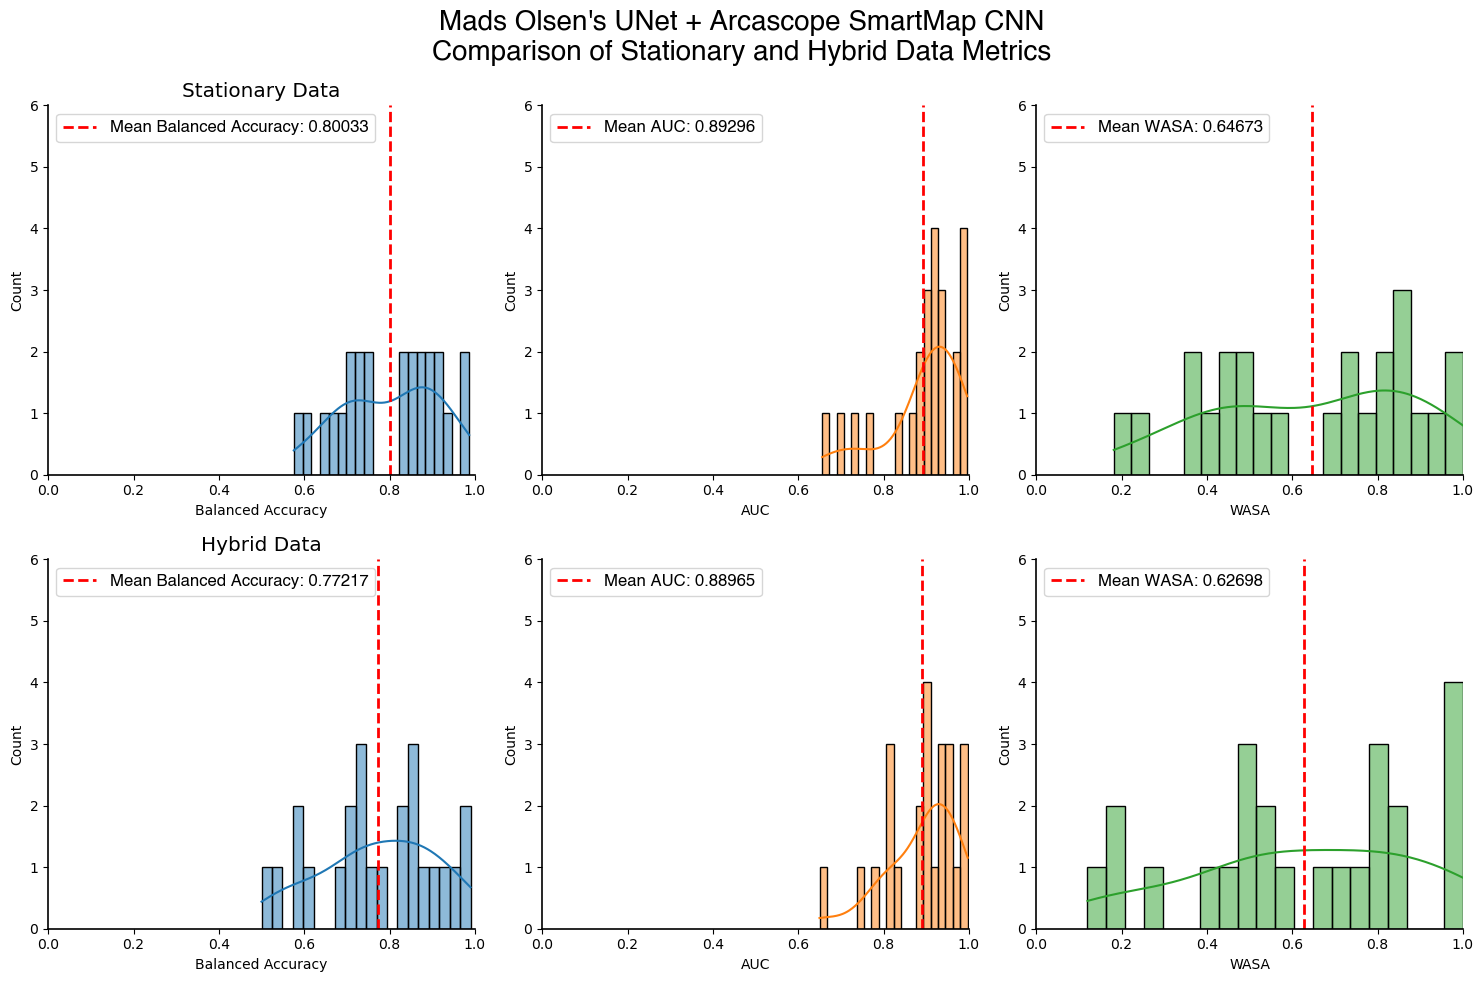

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

tri_plot_metrics(evaluations_df, axs=axs[0], axs_set_name="Stationary Data")
tri_plot_metrics(evaluations_df_hybrid, axs=axs[1], axs_set_name="Hybrid Data")

for ax in axs.flatten():
    ax.set_ylim(0, 6)

fig.suptitle("Mads Olsen's UNet + Arcascope SmartMap CNN\nComparison of Stationary and Hybrid Data Metrics", fontsize=20)

fig.tight_layout()
# fig.savefig(Path(os.getcwd()).joinpath("comparison_metrics_triplot.png"), dpi=600, bbox_inches='tight')

# Naive
Just take the (W, L, D, M) probability and set the prob of sleep to be 1 - (W,)

In [26]:

# Import necessary libraries
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

results = []
for idx in range(len(hybrid_preprocessed_data)):
    hybrid_weights = walch_data_bundle.sample_weights[idx].numpy()
    hybrid_labels = walch_data_bundle.true_labels[idx].numpy()
    hybrid_labels_masked = np.where(hybrid_weights, hybrid_labels, 0)
    hybrid_wldm_predictions = hybrid_data_bundle.mo_predictions[idx].numpy()
    hybrid_binary = naive_pred_proba(hybrid_wldm_predictions)

    eval = auroc_balaccuracy_wasa(
        hybrid_keys[idx], 
        hybrid_binary,
        hybrid_weights,
        hybrid_labels_masked)
    results.append(eval)

evaluations_df_naive_hybrid = pd.DataFrame(results, columns=EVALUATION_COLUMNS)

Fold 1066528
	ROC AUC: 0.6504486613709913
	Test WEIGHTED accuracy: 0.54902184009552
	WASA97: 0.12878787878787878 (17 / 132 || threshold: 0.6482334136962891)
Fold 1360686
	ROC AUC: 0.9752982436761295
	Test WEIGHTED accuracy: 0.9070888161659241
	WASA97: 0.8409090909090909 (74 / 88 || threshold: 0.6924972534179688)
Fold 1449548
	ROC AUC: 0.904832865825152
	Test WEIGHTED accuracy: 0.6434958577156067
	WASA97: 0.31521739130434784 (29 / 92 || threshold: 0.6720582246780396)
Fold 1455390
	ROC AUC: 0.7734913793103448
	Test WEIGHTED accuracy: 0.6674566268920898
	WASA97: 0.3625 (29 / 80 || threshold: 0.7673211097717285)
Fold 1818471
	ROC AUC: 0.9971518987341772
	Test WEIGHTED accuracy: 0.9926159977912903
	WASA97: 1.0 (10 / 10 || threshold: 0.6755151748657227)
Fold 2598705
	ROC AUC: 0.8802123552123553
	Test WEIGHTED accuracy: 0.5599417686462402
	WASA97: 0.14285714285714285 (2 / 14 || threshold: 0.5310819149017334)
Fold 2638030
	ROC AUC: 0.9300123183050012
	Test WEIGHTED accuracy: 0.7165555953979492

In [27]:

# Import necessary libraries
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

results = []
for idx in range(len(hybrid_preprocessed_data)):
    walch_weights = walch_data_bundle.sample_weights[idx].numpy()
    walch_labels = walch_data_bundle.true_labels[idx].numpy()
    walch_labels_masked = np.where(walch_weights, walch_labels, 0)
    walch_wldm_predictions = walch_data_bundle.mo_predictions[idx].numpy()
    walch_binary = naive_pred_proba(walch_wldm_predictions)

    eval = auroc_balaccuracy_wasa(
        walch_keys[idx], 
        walch_binary,
        walch_weights,
        walch_labels_masked)
    results.append(eval)

evaluations_df_naive_walch = pd.DataFrame(results, columns=EVALUATION_COLUMNS)

Fold 1066528
	ROC AUC: 0.7462366382269294
	Test WEIGHTED accuracy: 0.5528097152709961
	WASA97: 0.13636363636363635 (18 / 132 || threshold: 0.5799485445022583)
Fold 1360686
	ROC AUC: 0.9747735557273832
	Test WEIGHTED accuracy: 0.8882207870483398
	WASA97: 0.8068181818181818 (71 / 88 || threshold: 0.6794447898864746)
Fold 1449548
	ROC AUC: 0.8776808672276766
	Test WEIGHTED accuracy: 0.6591281294822693
	WASA97: 0.34782608695652173 (32 / 92 || threshold: 0.6462547779083252)
Fold 1455390
	ROC AUC: 0.7198132183908046
	Test WEIGHTED accuracy: 0.659482479095459
	WASA97: 0.35 (28 / 80 || threshold: 0.7344871759414673)
Fold 1818471
	ROC AUC: 0.9806962025316455
	Test WEIGHTED accuracy: 0.9394513368606567
	WASA97: 0.9 (9 / 10 || threshold: 0.6118409037590027)
Fold 2598705
	ROC AUC: 0.8693050193050194
	Test WEIGHTED accuracy: 0.6987450122833252
	WASA97: 0.42857142857142855 (6 / 14 || threshold: 0.5456297397613525)
Fold 2638030
	ROC AUC: 0.9240108401084011
	Test WEIGHTED accuracy: 0.8165410161018372


## Tri-plot Evaluation

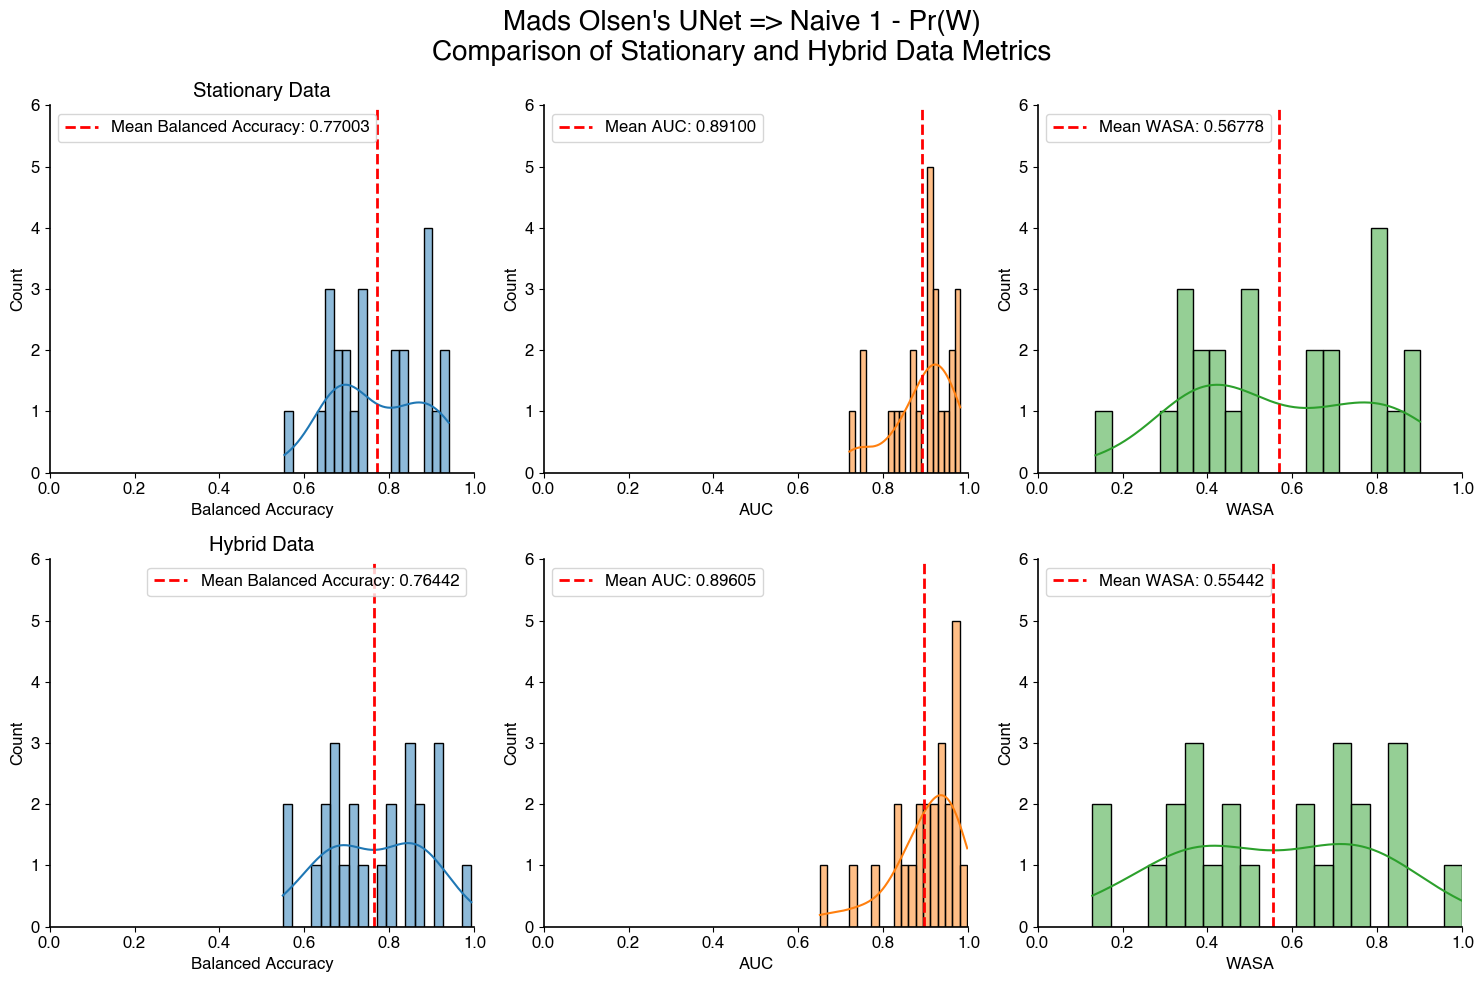

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

tri_plot_metrics(evaluations_df_naive_walch, axs=axs[0], axs_set_name="Stationary Data")
tri_plot_metrics(evaluations_df_naive_hybrid, axs=axs[1], axs_set_name="Hybrid Data")

for ax in axs.flatten():
    ax.set_ylim(0, 6)

fig.suptitle("Mads Olsen's UNet => Naive 1 - Pr(W)\nComparison of Stationary and Hybrid Data Metrics", fontsize=20)

fig.tight_layout()
# fig.savefig(Path(os.getcwd()).joinpath("comparison_metrics_triplot.png"), dpi=600, bbox_inches='tight')

# Log Reg

## Preprocessing

In [29]:
# import pisces.data_sets as pds
# pisces_data_location = '/Users/eric/Engineering/Work/pisces/data_sets'

# sets = pds.DataSetObject.find_data_sets(pisces_data_location)

# walch_data = sets['walch_et_al']
# walch_data.parse_data_sets()

# print(f"Found {len(walch_data.ids)} subjects (should be 31)")

# hybrid = sets['hybrid_motion']
# hybrid.parse_data_sets()

# print(f"Found {len(hybrid.ids)} subjects (should be 31)")
# log_reg_hyperparameters = {'penalty': None, 'alpha': 10.0, 'fit_intercept': False, 'learning_rate': 'adaptive', 'eta0': 0.0001, 'random_state': 42}
# output_type = pm.ModelOutputType.SLEEP_WAKE
# model_input = pm.ModelInput1D(
#     ['activity'],
#     1/15,
#     300)
# walch_data_processor = pds.DataProcessor(walch_data, model_input, output_type=output_type)

# def make_lr_model():
#     return pm.SGDLinearClassifier(walch_data_processor, **log_reg_hyperparameters)

# swc = make_lr_model()

# ids_to_preprocess_walch = [i for i in walch_data.ids if i not in subjects_to_exclude_walch]
# preprocessed_data_walch = {i: swc.get_needed_X_y(i) for i in ids_to_preprocess_walch}
# ids_to_preprocess_hybrid = [i for i in hybrid.ids if i not in subjects_to_exclude_hybrid]
# preprocessed_data_hybrid= {i: swc.get_needed_X_y(i) for i in ids_to_preprocess_hybrid}


## LR as a CNN model

## Train LR CNN

In [30]:

split_maker = pm.LeaveOneOutSplitter()

training_results = []
evaluations = []
predictors = []

print("Training models...")
print("Saving models to", walch_path)

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data = tf.reshape(
        tf.gather(walch_data_bundle.activity, train_idx_tensor),
        input_shape)
    train_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, train_idx_tensor),
        output_shape)
    train_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, train_idx_tensor),
        output_shape)
    # testing
    test_data = tf.reshape(
        tf.gather(walch_data_bundle.activity, test_idx_tensor),
        input_shape)
    test_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, test_idx_tensor),
        output_shape)
    test_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, test_idx_tensor),
        output_shape)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)
    test_labels_masked = tf.where(test_sample_weights > 0, test_labels, 0.0)

    # z-normalize input data
    train_data = (train_data - tf.reduce_mean(train_data)) / np.std(train_data)
    test_data = (test_data - tf.reduce_mean(test_data)) / np.std(test_data)


    # Custom loss function that includes the sample weights
    lr_cnn = build_lr_cnn()
    weighted_lr_cnn = WeightedModel(lr_cnn)
    weighted_lr_cnn.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        (train_data, train_labels_masked, train_sample_weights))
    dataset = dataset.batch(32)
    training_results.append(weighted_lr_cnn.fit(
        dataset,
        epochs=250, 
        verbose=0,
    ))


    binary_predicitions = lr_cnn_pred_proba(lr_cnn, test_data)

    accuracy_metrics = auroc_balaccuracy_wasa(
        walch_keys[k_test[0]],
        binary_predicitions,
        test_sample_weights.numpy(),
        test_labels_masked.numpy())

    # # Save all the results
    evaluations.append(accuracy_metrics)

    predictors.append(lr_cnn)
    # lr_cnn.save(walch_path.joinpath(f"{k_test[0]}_lr_cnn.h5"))


evaluations_df_lr = pd.DataFrame(evaluations, columns=EVALUATION_COLUMNS)


Training models...
Saving models to /Users/eric/Engineering/Work/sleepers_analysis/notebooks/fine_tuning/walch


Next split:   0%|          | 0/24 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Next split:   4%|▍         | 1/24 [00:00<00:19,  1.16it/s]

Fold 1066528
	ROC AUC: 0.6529677846425421
	Test WEIGHTED accuracy: 0.6134158372879028
	WASA97: 0.25757575757575757 (34 / 132 || threshold: 0.1922772377729416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Next split:   8%|▊         | 2/24 [00:01<00:18,  1.16it/s]

Fold 1360686
	ROC AUC: 0.6707445045841156
	Test WEIGHTED accuracy: 0.588085412979126
	WASA97: 0.19318181818181818 (17 / 88 || threshold: 0.17856481671333313)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  12%|█▎        | 3/24 [00:02<00:17,  1.17it/s]

Fold 1449548
	ROC AUC: 0.6908456054230948
	Test WEIGHTED accuracy: 0.6149777770042419
	WASA97: 0.2608695652173913 (24 / 92 || threshold: 0.35369235277175903)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  17%|█▋        | 4/24 [00:03<00:16,  1.18it/s]

Fold 1455390
	ROC AUC: 0.7081896551724138
	Test WEIGHTED accuracy: 0.6163071393966675
	WASA97: 0.2625 (21 / 80 || threshold: 0.27486637234687805)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Next split:  21%|██        | 5/24 [00:04<00:16,  1.17it/s]

Fold 1818471
	ROC AUC: 0.97457805907173
	Test WEIGHTED accuracy: 0.936286985874176
	WASA97: 0.9 (9 / 10 || threshold: 0.2206762731075287)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  25%|██▌       | 6/24 [00:05<00:15,  1.16it/s]

Fold 2598705
	ROC AUC: 0.7389961389961389
	Test WEIGHTED accuracy: 0.671814501285553
	WASA97: 0.35714285714285715 (5 / 14 || threshold: 0.2007780522108078)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  29%|██▉       | 7/24 [00:06<00:14,  1.15it/s]

Fold 2638030
	ROC AUC: 0.8222616407982262
	Test WEIGHTED accuracy: 0.7206206321716309
	WASA97: 0.4715447154471545 (58 / 123 || threshold: 0.40955349802970886)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  33%|███▎      | 8/24 [00:06<00:14,  1.14it/s]

Fold 3997827
	ROC AUC: 0.9224973089343381
	Test WEIGHTED accuracy: 0.7860062718391418
	WASA97: 0.6 (15 / 25 || threshold: 0.18403536081314087)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  38%|███▊      | 9/24 [00:07<00:13,  1.15it/s]

Fold 4018081
	ROC AUC: 0.812924545621443
	Test WEIGHTED accuracy: 0.6767944097518921
	WASA97: 0.38461538461538464 (25 / 65 || threshold: 0.25921931862831116)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Next split:  42%|████▏     | 10/24 [00:08<00:12,  1.15it/s]

Fold 4314139
	ROC AUC: 0.8264028853293732
	Test WEIGHTED accuracy: 0.6767502427101135
	WASA97: 0.3838383838383838 (38 / 99 || threshold: 0.27709344029426575)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Next split:  46%|████▌     | 11/24 [00:09<00:11,  1.15it/s]

Fold 4426783
	ROC AUC: 0.9230157632743362
	Test WEIGHTED accuracy: 0.8126382231712341
	WASA97: 0.65625 (42 / 64 || threshold: 0.4453416168689728)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Next split:  50%|█████     | 12/24 [00:10<00:10,  1.15it/s]

Fold 46343
	ROC AUC: 0.8267253245526436
	Test WEIGHTED accuracy: 0.6918708682060242
	WASA97: 0.4050632911392405 (32 / 79 || threshold: 0.17776069045066833)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Next split:  54%|█████▍    | 13/24 [00:11<00:09,  1.13it/s]

Fold 5498603
	ROC AUC: 0.7609479103573592
	Test WEIGHTED accuracy: 0.606019139289856
	WASA97: 0.2403846153846154 (25 / 104 || threshold: 0.13346877694129944)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  58%|█████▊    | 14/24 [00:12<00:08,  1.14it/s]

Fold 5797046
	ROC AUC: 0.7664749651676399
	Test WEIGHTED accuracy: 0.6326891779899597
	WASA97: 0.2911392405063291 (23 / 79 || threshold: 0.17587991058826447)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Next split:  62%|██████▎   | 15/24 [00:13<00:09,  1.03s/it]

Fold 6220552
	ROC AUC: 0.5997341565903439
	Test WEIGHTED accuracy: 0.5765055418014526
	WASA97: 0.17307692307692307 (9 / 52 || threshold: 0.16864503920078278)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  67%|██████▋   | 16/24 [00:14<00:07,  1.01it/s]

Fold 781756
	ROC AUC: 0.7604130104130105
	Test WEIGHTED accuracy: 0.6671788096427917
	WASA97: 0.36363636363636365 (28 / 77 || threshold: 0.2369595319032669)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Next split:  71%|███████   | 17/24 [00:15<00:06,  1.05it/s]

Fold 8000685
	ROC AUC: 0.5764092538286087
	Test WEIGHTED accuracy: 0.6500672101974487
	WASA97: 0.3225806451612903 (10 / 31 || threshold: 0.2567763030529022)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Next split:  75%|███████▌  | 18/24 [00:16<00:05,  1.06it/s]

Fold 8173033
	ROC AUC: 0.8184232178921386
	Test WEIGHTED accuracy: 0.7709813117980957
	WASA97: 0.5517241379310345 (16 / 29 || threshold: 0.13601860404014587)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  79%|███████▉  | 19/24 [00:17<00:04,  1.08it/s]

Fold 844359
	ROC AUC: 0.7954458476846537
	Test WEIGHTED accuracy: 0.6608988046646118
	WASA97: 0.3516483516483517 (32 / 91 || threshold: 0.2399587631225586)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  83%|████████▎ | 20/24 [00:17<00:03,  1.10it/s]

Fold 8530312
	ROC AUC: 0.5208057675996607
	Test WEIGHTED accuracy: 0.561246931552887
	WASA97: 0.14666666666666667 (11 / 75 || threshold: 0.12890954315662384)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  88%|████████▊ | 21/24 [00:18<00:02,  1.12it/s]

Fold 8686948
	ROC AUC: 0.802169924573603
	Test WEIGHTED accuracy: 0.7519875764846802
	WASA97: 0.5306122448979592 (26 / 49 || threshold: 0.27084213495254517)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  92%|█████████▏| 22/24 [00:19<00:01,  1.13it/s]

Fold 8692923
	ROC AUC: 0.6877827050997782
	Test WEIGHTED accuracy: 0.6762749552726746
	WASA97: 0.38181818181818183 (42 / 110 || threshold: 0.4664749503135681)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  96%|█████████▌| 23/24 [00:20<00:00,  1.13it/s]

Fold 9106476
	ROC AUC: 0.6986446191379777
	Test WEIGHTED accuracy: 0.6079766750335693
	WASA97: 0.24705882352941178 (21 / 85 || threshold: 0.26599064469337463)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s]

Fold 9618981
	ROC AUC: 0.8301640667025283
	Test WEIGHTED accuracy: 0.7630245089530945
	WASA97: 0.5568181818181818 (49 / 88 || threshold: 0.3815426230430603)


In [31]:

# Import necessary libraries
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

results = []
for idx in range(len(hybrid_preprocessed_data)):
    hybrid_weights = hybrid_data_bundle.sample_weights[idx].numpy()
    hybrid_labels = hybrid_data_bundle.true_labels[idx].numpy()
    hybrid_labels_masked = np.where(hybrid_weights, hybrid_labels, 0)

    eval = auroc_balaccuracy_wasa(
        hybrid_keys[idx], 
        lr_cnn_pred_proba(predictors[idx],
        hybrid_data_bundle.activity[idx].numpy()),
        hybrid_weights,
        hybrid_labels_masked)
    results.append(eval)

evaluations_df_lr_hybrid = pd.DataFrame(results, columns=EVALUATION_COLUMNS)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1066528
	ROC AUC: 0.6552485582889263
	Test WEIGHTED accuracy: 0.6170158386230469
	WASA97: 0.2631578947368421 (35 / 133 || threshold: 0.011715558357536793)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1360686
	ROC AUC: 0.6705786628420124
	Test WEIGHTED accuracy: 0.5880958437919617
	WASA97: 0.19318181818181818 (17 / 88 || threshold: 0.001463855616748333)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 1449548
	ROC AUC: 0.6898629899410336
	Test WEIGHTED accuracy: 0.5927419066429138
	WASA97: 0.21505376344086022 (20 / 93 || threshold: 0.0329136848449707)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 1455390
	ROC AUC: 0.711182063289343
	Test WEIGHTED accuracy: 0.6090888381004333
	WASA97: 0.24691358024691357 (20 / 81 || threshold: 0.005803992971777916)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 1818471
	ROC AUC: 0.9770042194092827
	Test WEIGHTED accuracy: 0.9357595443725586
	WASA97: 0.9 (9 / 10 || threshold: 0.014113507233560085)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

## Tri plot

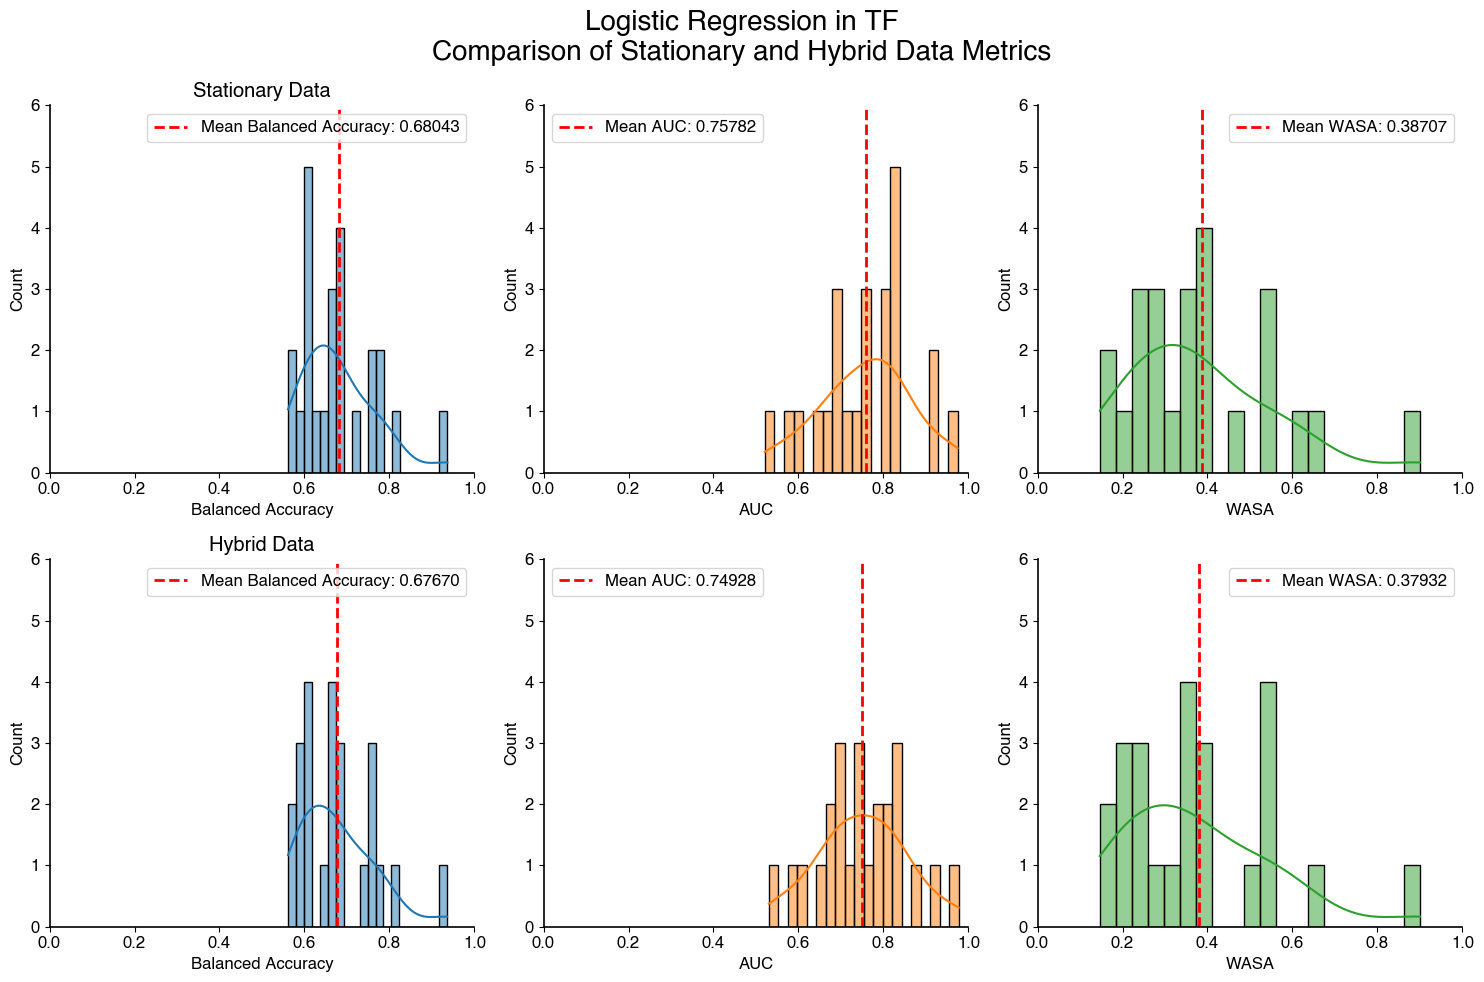

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

tri_plot_metrics(evaluations_df_lr, axs=axs[0], axs_set_name="Stationary Data")
tri_plot_metrics(evaluations_df_lr_hybrid, axs=axs[1], axs_set_name="Hybrid Data")

for ax in axs.flatten():
    ax.set_ylim(0, 6)

fig.suptitle("Logistic Regression in TF\nComparison of Stationary and Hybrid Data Metrics", fontsize=20)

fig.tight_layout()
# fig.savefig(Path(os.getcwd()).joinpath("comparison_metrics_triplot.png"), dpi=600, bbox_inches='tight')

## Ranked debug plots

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


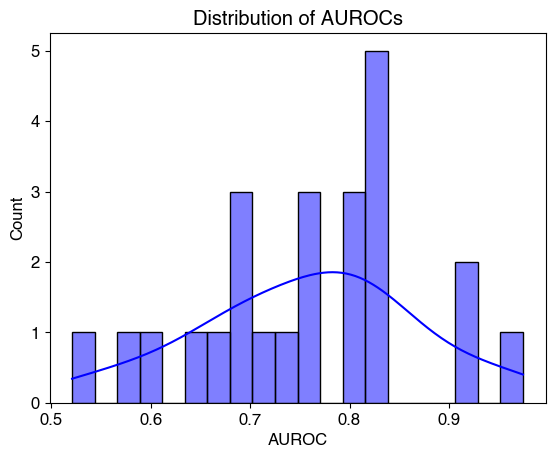

In [33]:
ranked_debug_plots(
    evaluations_df_lr,
    walch_data_bundle.activity.numpy(),
    walch_data_bundle.true_labels.numpy(),
    predictors,
    lr_cnn_pred_proba,
    walch_data_bundle.spectrogram.numpy(),
    "_lr_cnn_eval",
    "lr",
    walch_keys
)